# 预处理	
* 输入：/cluster/home/futing/Project/GBM/HiC/hubgene/new/RNAprepro.ipynb
* 选择E-Ploop	
* 合并RNA表达上下调情况，统计在loop中出现情况

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns
import numpy as np  # 导入 numpy
from scipy.stats import kruskal
import glob

# font_manager.fontManager.ttflist.append(font_manager.FontProperties(fname='/cluster/home/futing/miniforge-pypy3/envs/HiC/fonts/Arial.ttf'))
# arial_font = font_manager.FontProperties(fname='Arial.ttf')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['pdf.fonttype'] = 42

In [3]:
font_files = font_manager.findSystemFonts(fontpaths='/cluster/home/futing/miniforge-pypy3/envs/HiC/fonts/')
 
for file in font_files:
    font_manager.fontManager.addfont(file)

### 筛选 E-P
输入文件来源于pre.sh，获得*_chip.bedpe

In [3]:
import os

def check_overlap(anchor, region):
    """
    检查两个区域是否有交集
    参数:
        anchor: 锚点区域 (chrom, start, end)
        region: 另一个区域 (chrom, start, end)
    返回:
        如果有交集则返回 True，否则返回 False
    """
    chrom1, start1, end1 = anchor
    chrom2, start2, end2 = region
    return chrom1 == chrom2 and start1 < end2 and end1 > start2

def filter_bedpe(file_path, output_path):
    """
    筛选出基因和增强子有且只有一个与锚点交集的行
    并添加一列，表明锚点与基因或增强子有重叠
    """
    with open(file_path, 'r') as infile, open(output_path, 'w') as outfile:
        for line in infile:
            columns = line.strip().split('\t')
            
            # 锚点的染色体号、起始位置、终止位置（前三列）
            anchor = (columns[0], int(columns[1]), int(columns[2]))
            
            # 基因的染色体、起始位置、终止位置（第7-9列）
            gene = (columns[7], int(columns[8]), int(columns[9]))
            
            # 增强子的染色体、起始位置、终止位置（第11-13列）
            enhancer = (columns[11], int(columns[12]), int(columns[13]))
            
            # 判断基因和增强子是否与锚点有交集
            gene_overlap = check_overlap(anchor, gene)
            enhancer_overlap = check_overlap(anchor, enhancer)
            
            # 筛选出基因和增强子有且只有一个与锚点交集的行
            if gene_overlap != enhancer_overlap:
                overlap_type = "Gene" if gene_overlap else "Enhancer"
                outfile.write(f"{line.strip()}\t{overlap_type}\n")

def batch_process(files, output_dir):
    """
    批量处理多个文件
    """
    for file in files:
        file_path = os.path.join(output_dir, file)
        output_path = os.path.join(output_dir, f"filtered_{file}")
        filter_bedpe(file_path, output_path)
        print(f"已处理文件: {file}")

# 文件列表
files = ["GBM_chip.bedpe", "NHA_chip.bedpe", "iPSC_chip.bedpe", "NPC_chip.bedpe"]
output_dir = "/cluster/home/tmp/GBM/HiC/hubgene/new/chip/merge"  # 输出目录

# 批量处理文件
batch_process(files, output_dir)


已处理文件: GBM_chip.bedpe
已处理文件: NHA_chip.bedpe
已处理文件: iPSC_chip.bedpe
已处理文件: NPC_chip.bedpe


In [7]:
import os

def count_gene_occurrences(bedpe_file, gene_column_index=10):
    """
    统计基因在 bedpe 文件中指定列的出现次数
    """
    gene_counts = {}
    with open(bedpe_file, 'r') as infile:
        for line in infile:
            columns = line.strip().split('\t')
            gene = columns[gene_column_index]  # 第 10 列（索引 9）是基因
            if gene not in gene_counts:
                gene_counts[gene] = 0
            gene_counts[gene] += 1
    return gene_counts

def update_gene_expression_file(gene_expression_file, bedpe_files, output_file):
    """
    更新基因表达文件，将每个 bedpe 文件中的基因计数作为新列添加，同时保留原始数据
    """
    # 读取基因表达文件
    with open(gene_expression_file, 'r') as infile:
        lines = infile.readlines()

    # 提取表头和数据
    header = lines[0].strip().split('\t')
    data = [line.strip().split('\t') for line in lines[1:]]

    # 提取基因名列表
    gene_names = [row[0] for row in data]

    # 创建一个字典来存储每个基因在每个文件中的计数
    gene_counts = {gene: {file.split('_')[1]: 0 for file in bedpe_files} for gene in gene_names}

    # 统计每个 bedpe 文件中基因的出现次数
    for bedpe_file in bedpe_files:
        file_name = bedpe_file.split('_')[1]  # 提取文件名的中间部分作为列名
        counts = count_gene_occurrences(bedpe_file)
        
        # 更新 gene_counts 字典
        for gene, count in counts.items():
            if gene in gene_counts:
                gene_counts[gene][file_name] = count

    # 写入新文件
    with open(output_file, 'w') as outfile:
        # 构建新表头：原表头 + 新列
        new_columns = [file.split('_')[1] for file in bedpe_files]
        new_header = header + new_columns
        outfile.write('\t'.join(new_header) + '\n')

        # 构建每一行数据并写入
        for row in data:
            gene = row[0]
            original_columns = row[1:]  # 原始的其他列
            counts = [str(gene_counts[gene].get(file.split('_')[1], 0)) for file in bedpe_files]
            new_row = row + counts  # 保留原数据列，并追加新计数列
            outfile.write('\t'.join(new_row) + '\n')

# 文件路径设置
gene_expression_file = "/cluster/home/tmp/GBM/RNA/subtype_TPM/count_merge/PCGene_Expression_Categories_GBM_vs_NPC_iPSC_NHA.txt"
bedpe_files = [
    "/cluster/home/tmp/GBM/HiC/hubgene/new/chip/merge/filtered_GBM_chip.bedpe",
    "/cluster/home/tmp/GBM/HiC/hubgene/new/chip/merge/filtered_NHA_chip.bedpe",
    "/cluster/home/tmp/GBM/HiC/hubgene/new/chip/merge/filtered_iPSC_chip.bedpe",
    "/cluster/home/tmp/GBM/HiC/hubgene/new/chip/merge/filtered_NPC_chip.bedpe"
]
output_file = "/cluster/home/tmp/GBM/RNA/subtype_TPM/count_merge/Updated_PCGene_Expression_Categories_GBM_vs_NPC_iPSC_NHA.txt"

# 执行更新
update_gene_expression_file(gene_expression_file, bedpe_files, output_file)


# 绘图

#### 受不同数量 Enhancer 调控 Gene 数量的分布	
受一个E调控的G数量有多少，两个E调控的G数量有多少

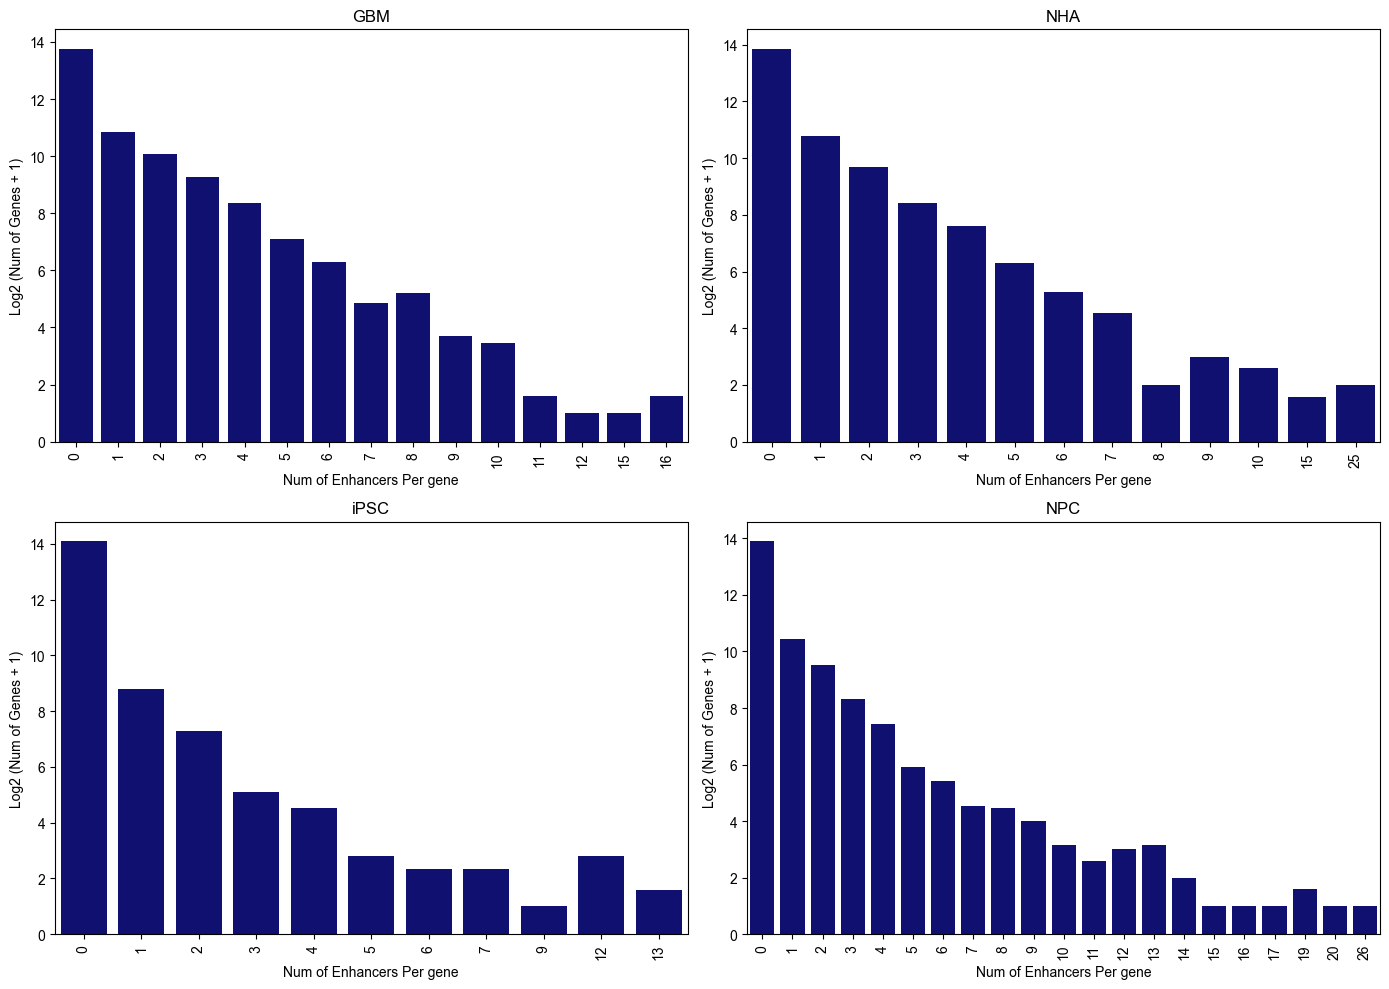

In [9]:
# 读取文件
file_path = "/cluster/home/tmp/GBM/RNA/subtype_TPM/count_merge/Updated_PCGene_Expression_Categories_GBM_vs_NPC_iPSC_NHA.txt"
df = pd.read_csv(file_path, sep='\t')

# 获取第7到第10列的列名
columns_to_plot = df.columns[4:8]

# 创建 2x2 的子图
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# 遍历第7到第10列，分别绘制每列的基因计数
for i, col in enumerate(columns_to_plot):
    # 获取当前的子图
    ax = axs[i//2, i%2]
    
    # 统计当前列基因出现的次数
    gene_counts = df[col].value_counts()
    
    # 对 gene_counts 进行 log2(x+1) 转换
    gene_counts_log2 = np.log2(gene_counts + 1)
    
    # 绘制柱状图
    sns.barplot(x=gene_counts.index, y=gene_counts_log2.values, ax=ax, color='navy')
    
    # 设置每个子图的标题和标签
    title = col.replace('_merged_G', '')  # 或 col.split('_merged_G')[0]
    ax.set_title(f"{title}")
    ax.set_xlabel('Num of Enhancers Per gene')
    ax.set_ylabel('Log2 (Num of Genes + 1)')  # 修改纵轴标签，反映 log2 转换
    ax.tick_params(axis='x', rotation=90)  # 旋转 x 轴标签，防止重叠

# 调整布局以防止子图重叠
plt.tight_layout()

# 显示图表
plt.savefig("/cluster/home/tmp/GBM/HiC/hubgene/new/chip/num_loop_by_enh.pdf", format='pdf')

# 显示图表
plt.show()


#### ChIP 信号的覆盖率	
* 来源于pre.sh

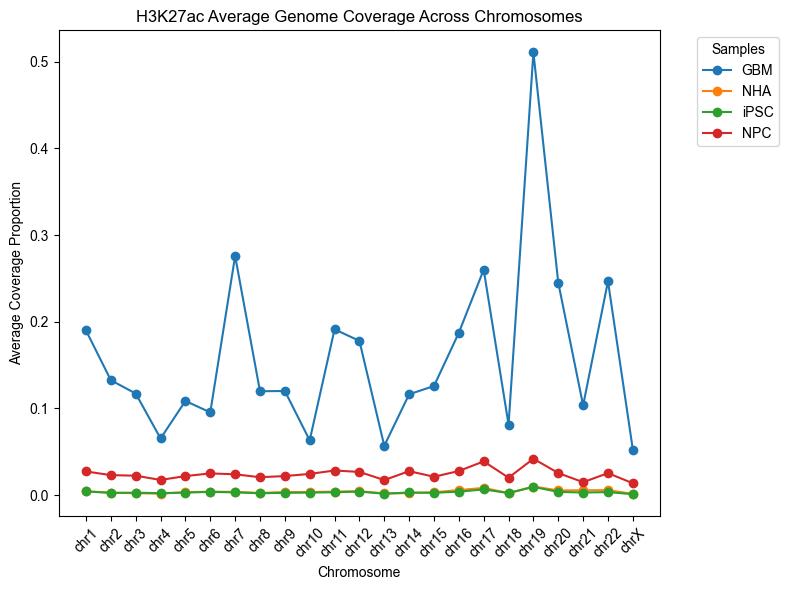

In [ ]:


# 获取所有 *_chip_coverage.txt 文件路径
file_paths = glob.glob('/cluster/home/tmp/GBM/HiC/hubgene/new/chip/merge/*_chip_coverage.txt')

plt.figure(figsize=(8, 6))

# 遍历每个文件并绘制线图
for file_path in file_paths:
    # 读取文件
    coverage = pd.read_csv(
        file_path,
        sep='\t',
        header=None,
        names=['chrom', 'start', 'end', 'col4', 'col5', 'col6', 'coverage']
    )

    # 按染色体计算平均覆盖度
    chrom_avg_coverage = coverage.groupby('chrom')['coverage'].mean().reset_index()

    # 按染色体顺序排序（保证线图顺序一致）
    chrom_avg_coverage['chrom'] = pd.Categorical(
        chrom_avg_coverage['chrom'], 
        categories=[f'chr{i}' for i in range(1, 23)] + ['chrX'], 
        ordered=True
    )
    chrom_avg_coverage = chrom_avg_coverage.sort_values('chrom')

    # 只保留 chr1 到 chr22 和 chrX 的数据
    chrom_avg_coverage = chrom_avg_coverage[chrom_avg_coverage['chrom'].isin([f'chr{i}' for i in range(1, 23)] + ['chrX'])]

    # 获取文件名（用于图例显示）
    sample_name = file_path.split('/')[-1].replace('_chip_coverage.txt', '')

    # 绘制线图
    plt.plot(
        chrom_avg_coverage['chrom'], 
        chrom_avg_coverage['coverage'], 
        marker='o', 
        linestyle='-', 
        label=sample_name
    )

# 设置图例和轴标签
plt.xlabel('Chromosome')
plt.ylabel('Average Coverage Proportion')
plt.title('H3K27ac Average Genome Coverage Across Chromosomes')
plt.legend(title='Samples', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)  # 调整X轴染色体号显示角度
plt.tight_layout()
plt.savefig("/cluster/home/tmp/GBM/HiC/hubgene/new/chip/cvg_h3k27ac.pdf", format='pdf')

plt.show()


### 上调基因受更多Enhancer的调控	
来源于 pre.sh
*	基因上调情况：RNA DeSeq2	
*	每个基因受 Enhancer 调控情况

In [5]:
df.head()

,Gene,GBM_vs_NPC,GBM_vs_iPSC,GBM_vs_NHA,GBM,NHA,iPSC,NPC
0,A1BG,Downregulated in GBM,No significant change,No significant change,0,0,0,0
1,A1CF,NaN,No significant change,No significant change,0,0,0,0
2,A2M,Upregulated in GBM,Upregulated in GBM,No significant change,0,0,0,0
3,A2ML1,No significant change,No significant change,Upregulated in GBM,1,0,0,0
4,A3GALT2,NaN,No significant change,No significant change,0,0,0,0


In [6]:
df['GBM'].value_counts()

GBM
0     13810
1      1861
2      1083
3       620
4       328
5       136
6        77
8        36
7        28
9        12
10       10
11        2
16        2
12        1
15        1
Name: count, dtype: int64

Processing 0 and GBM_vs_NHA...
Processing GBM...
Processing 1 and GBM_vs_NPC...
Processing GBM...
Processing 2 and GBM_vs_iPSC...
Processing GBM...


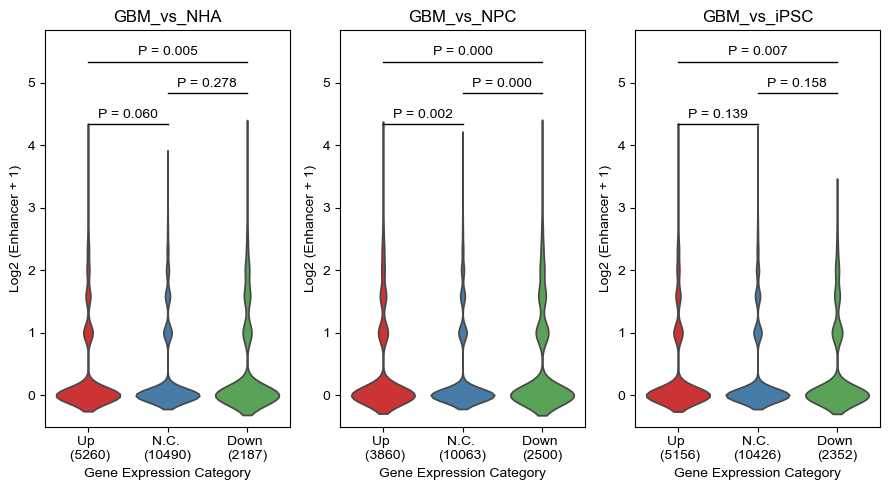

In [4]:
# 读取文件
file_path = "/cluster/home/futing/Project/GBM/RNA/subtype_TPM/count_merge/Updated_PCGene_Expression_Categories_GBM_vs_NPC_iPSC_NHA.txt"
df = pd.read_csv(file_path, sep='\t')

# 创建一个列表保存每组需要的列名
exp_columns = ['GBM_vs_NHA', 'GBM_vs_NPC', 'GBM_vs_iPSC']  # 用于分类的列
enhancer_columns = ['GBM']  # 需要进行log转化的列

# 设置绘图区域：1x3 网格
fig, axes = plt.subplots(1, 3, figsize=(9, 5))

# 遍历 exp_columns 进行绘图
for i, tpm_col in enumerate(exp_columns):
    print(f'Processing {i} and {tpm_col}...')
    
    # 筛选非NA行
    df_clean = df.dropna(subset=[tpm_col]).copy()  # 使用 .copy() 以避免警告

    # 创建 log2(TPM+1) 列，只对 enhancer_columns 列进行 log 转换
    for enhancer_col in enhancer_columns:
        print(f'Processing {enhancer_col}...')
        df_clean.loc[:, f'log2_{enhancer_col}_plus_1'] = np.log2(df_clean.loc[:, enhancer_col] + 1)

        # 使用现有的分类，将 "Downregulated in GBM" 改为 "Down" 等
        df_clean.loc[:, 'expression_category'] = df_clean[tpm_col].replace({
            'Downregulated in GBM': 'Down',
            'Upregulated in GBM': 'Up',
            'No significant change': 'N.C.'
        })

        # 计算各分类中的基因数量
        up_count = df_clean[df_clean['expression_category'] == 'Up'].shape[0]
        nc_count = df_clean[df_clean['expression_category'] == 'N.C.'].shape[0]
        down_count = df_clean[df_clean['expression_category'] == 'Down'].shape[0]

        # 绘制箱线图：x 为分类（Up, N.C., Down），y 为 log2 转换后的表达值
        # sns.boxplot(data=df_clean, x='expression_category', y=f'log2_{enhancer_col}_plus_1', ax=axes[i], order=['Up', 'N.C.', 'Down'])
        sns.violinplot(data=df_clean, x='expression_category', y=f'log2_{enhancer_col}_plus_1', ax=axes[i], order=['Up', 'N.C.', 'Down'],
                       hue='expression_category',hue_order=['Up', 'N.C.', 'Down'],palette="Set1",inner=None)

        # ---- 设置标题和标签
        y_position = max(df_clean[f'log2_{enhancer_col}_plus_1']) + 0.25  # 通过数据的最大值动态设置 p 值的位置
        upper=0.5
        axes[i].set_title(f"{tpm_col}",fontsize=12)
        axes[i].set_xlabel("Gene Expression Category")
        axes[i].set_ylabel(f"Log2 (Enhancer + 1)")
        axes[i].set_ylim(-0.5,y_position + upper*3)
        # 修改箱线图横轴的标签为基因数量
        axes[i].set_xticks([0, 1, 2])  # 设置刻度位置
        axes[i].set_xticklabels([f'Up \n ({up_count})', f'N.C. \n({nc_count})', f'Down \n({down_count})'])

        # ---- p值
        # 进行 Kruskal-Wallis H 检验
        down = df_clean[df_clean['expression_category'] == 'Down'][f'log2_{enhancer_col}_plus_1']
        up = df_clean[df_clean['expression_category'] == 'Up'][f'log2_{enhancer_col}_plus_1']
        nc = df_clean[df_clean['expression_category'] == 'N.C.'][f'log2_{enhancer_col}_plus_1']

        # 进行两两比较
        p_down_up = kruskal(down, up).pvalue
        p_down_nc = kruskal(down, nc).pvalue
        p_up_nc = kruskal(up, nc).pvalue

        # 连接组之间的线条
        axes[i].plot([0, 1], [y_position, y_position], color='black', lw=1)
        axes[i].plot([1, 2], [y_position + upper, y_position + upper], color='black', lw=1)
        axes[i].plot([0, 2], [y_position + upper*2, y_position + upper*2], color='black', lw=1)

        # 在每个线条上方标注 p 值
        axes[i].text(0.5, y_position + 0.05, f'P = {p_down_up:.3f}', ha='center', va='bottom', fontsize=10, color='black')
        axes[i].text(1.5, y_position + upper + 0.05, f'P = {p_up_nc:.3f}', ha='center', va='bottom', fontsize=10, color='black')
        axes[i].text(1, y_position + upper*2 + 0.05, f'P = {p_down_nc:.3f}', ha='center', va='bottom', fontsize=10, color='black')

# 调整布局
plt.tight_layout()
# output_path = "/cluster/home/tmp/GBM/HiC/hubgene/new/chip/loop_enh_comparison_vln.pdf"
# plt.savefig(output_path, format='pdf', dpi=500)  # 保存为 PDF


In [8]:
df.head()

,Gene,GBM_vs_NPC,GBM_vs_iPSC,GBM_vs_NHA,GBM,NHA,iPSC,NPC
0,A1BG,Downregulated in GBM,No significant change,No significant change,0,0,0,0
1,A1CF,NaN,No significant change,No significant change,0,0,0,0
2,A2M,Upregulated in GBM,Upregulated in GBM,No significant change,0,0,0,0
3,A2ML1,No significant change,No significant change,Upregulated in GBM,1,0,0,0
4,A3GALT2,NaN,No significant change,No significant change,0,0,0,0


Processing $0, GBM_vs_NHA and NHA...
Processing $1, GBM_vs_NPC and NPC...
Processing $2, GBM_vs_iPSC and iPSC...


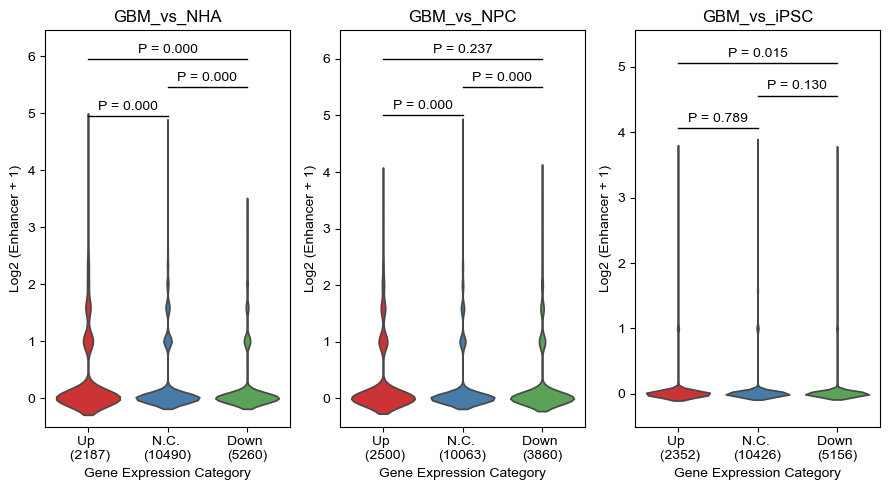

In [7]:
# 在GBM中上调/下调的基因，在不同对照组的增强子数量
file_path = "/cluster/home/futing/Project/GBM/RNA/subtype_TPM/count_merge/Updated_PCGene_Expression_Categories_GBM_vs_NPC_iPSC_NHA.txt"
df = pd.read_csv(file_path, sep='\t')

# 创建一个列表保存每组需要的列名
exp_columns = ['GBM_vs_NHA', 'GBM_vs_NPC', 'GBM_vs_iPSC']  # 用于分类的列
y_labels = ['NHA', 'NPC', 'iPSC']  # 对应的纵轴数据列名称

# 设置绘图区域：1x3 网格
fig, axes = plt.subplots(1, 3, figsize=(9, 5))

# 遍历 exp_columns 进行绘图
for i, (tpm_col, y_label) in enumerate(zip(exp_columns, y_labels)):
	print(f'Processing ${i}, {tpm_col} and {y_label}...')
	
	# 筛选非NA行
	df_clean = df.dropna(subset=[tpm_col]).copy()

	# 对 NHA, NPC, iPSC 列进行 log2 转换
	df_clean.loc[:,f'log2_{y_label}_plus_1'] = np.log2(df_clean[y_label] + 1)

	# 使用现有的分类，将 "Downregulated in GBM" 改为 "Up" 等
	df_clean.loc[:,'expression_category'] = df_clean[tpm_col].replace({
		'Downregulated in GBM': 'Up',
		'Upregulated in GBM': 'Down',
		'No significant change': 'N.C.'
	})

	# 计算各分类中的基因数量
	up_count = df_clean[df_clean['expression_category'] == 'Up'].shape[0]
	nc_count = df_clean[df_clean['expression_category'] == 'N.C.'].shape[0]
	down_count = df_clean[df_clean['expression_category'] == 'Down'].shape[0]

	# 绘制箱线图：x 为分类（Up, N.C., Down），y 为 log2 转换后的表达值
	# sns.boxplot(data=df_clean, x='expression_category', y=f'log2_{y_label}_plus_1', ax=axes[i], order=['Up', 'N.C.', 'Down'])
	sns.violinplot(data=df_clean, x='expression_category', y=f'log2_{y_label}_plus_1', ax=axes[i], order=['Up', 'N.C.', 'Down'],
				hue='expression_category',hue_order=['Up', 'N.C.', 'Down'],palette="Set1",inner=None)

	# ---- 设置标题和标签
	y_position = max(df_clean[f'log2_{y_label}_plus_1']) + 0.25  # 通过数据的最大值动态设置 p 值的位置
	upper=0.5
	axes[i].set_title(f"{tpm_col}")
	axes[i].set_xlabel("Gene Expression Category")
	axes[i].set_ylabel(f"Log2 (Enhancer + 1)")
	axes[i].set_ylim(-0.5,y_position + upper*3)
	# 修改箱线图横轴的标签为基因数量
	axes[i].set_xticks([0, 1, 2])  # 设置刻度位置
	axes[i].set_xticklabels([f'Up \n ({up_count})', f'N.C. \n({nc_count})', f'Down \n({down_count})'])

	# ---- 处理两组p值
	# 进行 Kruskal-Wallis H 检验
	down = df_clean[df_clean['expression_category'] == 'Down'][f'log2_{y_label}_plus_1']
	up = df_clean[df_clean['expression_category'] == 'Up'][f'log2_{y_label}_plus_1']
	nc = df_clean[df_clean['expression_category'] == 'N.C.'][f'log2_{y_label}_plus_1']

	# 进行两两比较
	p_down_up = kruskal(down, up).pvalue
	p_down_nc = kruskal(down, nc).pvalue
	p_up_nc = kruskal(up, nc).pvalue

	# 连接组之间的线条
	axes[i].plot([0, 1], [y_position, y_position], color='black', lw=1)
	axes[i].plot([1, 2], [y_position + upper, y_position + upper], color='black', lw=1)
	axes[i].plot([0, 2], [y_position + upper*2, y_position + upper*2], color='black', lw=1)

	# 在每个线条上方标注 p 值
	axes[i].text(0.5, y_position + 0.05, f'P = {p_down_up:.3f}', ha='center', va='bottom', fontsize=10, color='black')
	axes[i].text(1.5, y_position + upper + 0.05, f'P = {p_up_nc:.3f}', ha='center', va='bottom', fontsize=10, color='black')
	axes[i].text(1, y_position + upper*2 + 0.05, f'P = {p_down_nc:.3f}', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
# plt.savefig('/cluster/home/futing/Project/GBM/HiC/hubgene/new/chip/loop_enh_ctrl_vln.pdf',dpi=500)
